## 1. Setting up the environment

In [2]:
import numpy as np
import gym

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
# setting manual seed
torch.manual_seed(0)

from parallelEnv import parallelEnv

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# imports for rendering outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [3]:
# lets set up the cartpole environment
env = gym.make('Pendulum-v0')
env.seed(0)

# lets find about the action and state space
print("Action space: {} ... State space: {}".format(env.action_space,env.observation_space))

# lets print some info about action space range
action_high = env.action_space.high
action_low = env.action_space.low
print("action_high: {}\t action_low: {}".format(action_high,action_low))

Action space: Box(1,) ... State space: Box(3,)
action_high: [2.]	 action_low: [-2.]


In [4]:
# lets play a random episode

# reset env
state = env.reset()
step_count = 0
done = False

while (not done):
    # random action
    action = env.action_space.sample()
    # taking step in env
    next_state,reward,done,_ = env.step(action)
    
    # displaying progress
    print ("Step : {} ... state: {} ... action: {} ... reward: {} ... done: {}".format(step_count,
                                                                                       state,action,reward,done))
    
    # updating state and step count
    state = next_state
    step_count+=1

Step : 0 ... state: [-0.94223519 -0.33495202  0.93078187] ... action: [0.19525401] ... reward: -7.926888357788497 ... done: False
Step : 1 ... state: [-0.92977428 -0.36813012  0.70885596] ... action: [0.86075747] ... reward: -7.6939771290583225 ... done: False
Step : 2 ... state: [-0.91906665 -0.39410213  0.56187199] ... action: [0.4110535] ... reward: -7.52018189583656 ... done: False
Step : 3 ... state: [-0.91248103 -0.40911902  0.32795343] ... action: [0.17953274] ... reward: -7.409754858726039 ... done: False
Step : 4 ... state: [-0.91149561 -0.4113098   0.04804407] ... action: [-0.3053808] ... reward: -7.386228644680105 ... done: False
Step : 5 ... state: [-0.91768659 -0.39730506 -0.3062454 ] ... action: [0.58357644] ... reward: -7.47908659136635 ... done: False
Step : 6 ... state: [-0.92764336 -0.37346725 -0.51668773] ... action: [-0.24965115] ... reward: -7.63800526593766 ... done: False
Step : 7 ... state: [-0.94240996 -0.33445996 -0.83423584] ... action: [1.5670921] ... reward

Step : 103 ... state: [-0.95665851 -0.2912121   1.00503606] ... action: [1.8487542] ... reward: -8.204707397150514 ... done: False
Step : 104 ... state: [-0.93982089 -0.34166752  1.06394011] ... action: [-1.0049875] ... reward: -7.914508641073295 ... done: False
Step : 105 ... state: [-0.92809318 -0.37234802  0.65694135] ... action: [0.30462933] ... reward: -7.661153424846919 ... done: False
Step : 106 ... state: [-0.92000369 -0.39190969  0.42337473] ... action: [0.36816773] ... reward: -7.519557958046227 ... done: False
Step : 107 ... state: [-0.91634587 -0.40038761  0.18466762] ... action: [0.28900763] ... reward: -7.45449842730149 ... done: False
Step : 108 ... state: [-0.91778673 -0.3970737  -0.07227194] ... action: [-1.1076735] ... reward: -7.472494741730429 ... done: False
Step : 109 ... state: [-0.9281017  -0.37232678 -0.53622824] ... action: [1.810996] ... reward: -7.650063575696138 ... done: False
Step : 110 ... state: [-0.93788139 -0.34695606 -0.54382392] ... action: [-0.2114

## 2. Defining the policy

In [5]:
# defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("using",device)

using cuda:0


In [6]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

# define actor critic network
class ActorCritic(nn.Module):
    
    def __init__(self,state_size,action_size,action_high,action_low,hidden_size=32):
        super(ActorCritic, self).__init__()
        
        # action range
        self.action_high = torch.tensor(action_high).to(device)
        self.action_low = torch.tensor(action_low).to(device)
        
        self.std = nn.Parameter(torch.zeros(action_size))
        
        # common network
        self.fc1 = nn.Linear(state_size,128)
        
        # actor network
        self.fc2_actor = nn.Linear(128,64)
        self.fc3_action = nn.Linear(64,action_size)
        #self.fc3_std = nn.Linear(64,action_size)
        
        # critic network
        self.fc2_critic = nn.Linear(128,64)
        self.fc3_critic = nn.Linear(64,1)
    
    def forward(self,state):
        # common network
        x = F.relu(self.fc1(state))
        
        # actor network
        x_actor = F.relu(self.fc2_actor(x))
        action_mean = F.sigmoid(self.fc3_action(x_actor))
        ## rescale action mean
        action_mean_ = (self.action_high-self.action_low)*action_mean + self.action_low
        #action_std = F.sigmoid(self.fc3_std(x_actor))
        
        # critic network
        x_critic = F.relu(self.fc2_critic(x))
        v = self.fc3_critic(x_critic)
        return action_mean_,v
    
    def act(self,state):
        # converting state from numpy array to pytorch tensor on the "device"
        state = torch.from_numpy(state).float().to(device)
        action_mean,v = self.forward(state)
        prob_dist = Normal(action_mean,F.softplus(self.std))
        action = prob_dist.sample()
        log_prob = prob_dist.log_prob(action)
        return action.cpu().numpy(),torch.sum(log_prob,dim=1),v.squeeze()

## 3. Defining the RL agent

In [7]:
from collections import deque
from itertools import accumulate

def compute_future_rewards(rewards,gamma):
    future_rewards = np.zeros_like(rewards)
    discounted_rewards = np.zeros(rewards.shape[0])
    
    for time_step in range(future_rewards.shape[1]-1,-1,-1):
        future_rewards[:,time_step] = rewards[:,time_step] + gamma*discounted_rewards
        discounted_rewards = future_rewards[:,time_step]
    return future_rewards

class Agent:
    
    def __init__(self,env_name,learning_rate=1e-3):
        self.env = parallelEnv(env_name=env_name,n=8,seed=0)
        nS = env.observation_space.shape[0]
        nA = env.action_space.shape[0]
        self.policy = ActorCritic(state_size=nS,hidden_size=128,action_size=nA,
                             action_low=action_low,action_high=action_high).to(device)
        self.optimizer = optim.RMSprop(self.policy.parameters(), lr=learning_rate)
        
    def train(self,max_opt_steps=1000,num_trajectories=8,horizon=1000,gamma=.99,target_score= -250,
              PRINT_EVERY=100):
        # store eps scores
        scores = []
        scores_window = deque(maxlen=100)
        
        for opt_step in range(1,max_opt_steps+1):
            rewards = np.zeros([num_trajectories,horizon])
            log_probs = torch.zeros([num_trajectories,horizon],dtype=torch.double,device=device)
            value_estimate = torch.zeros([num_trajectories,horizon],dtype=torch.double,device=device)
            
            for traj_count in range(1):
                # reset state
                state = self.env.reset()
            
                # play an episode
                for t in range(horizon): 
                    action,log_prob,v = self.policy.act(state)
                    next_state,reward,done,_ = self.env.step(action)

                    # update state
                    state = next_state
                    log_probs[:,t] = log_prob
                    rewards[:,t] = reward
                    value_estimate[:,t] = v
                    
                    # break if done
                    if np.any(done):
                        break
            
            # compute advantage estimate to reduce variance
            future_rewards = compute_future_rewards(rewards,gamma)
            future_rewards = torch.from_numpy(future_rewards).double().to(device)
            # b = future_rewards.mean(axis=0)
            # A = (future_rewards - b)/future_rewards.std(axis=0)
            # A = torch.from_numpy(A).double().to(device)
            
            A = future_rewards-value_estimate
            
            # compute loss and applying gradient
            actor_loss = torch.sum(-log_probs*A)/(num_trajectories*horizon)
            
            undiscounted_future_rewards = compute_future_rewards(rewards,gamma=1.0)
            undiscounted_future_rewards = torch.from_numpy(undiscounted_future_rewards).double().to(device)
            critic_loss = torch.sum((undiscounted_future_rewards-value_estimate)**2)/(num_trajectories*horizon)
            
            # total loss
            loss = actor_loss + critic_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            trajectory_total_rewards = rewards.sum(axis=1)
            # update scores and score_window
            scores.append(np.mean(trajectory_total_rewards))
            scores_window.append(np.mean(trajectory_total_rewards))
            
            #printing progress
            if opt_step % PRINT_EVERY == 0:
                print ("Episode: {}\t Avg reward: {:.2f}\t std: {}".format(opt_step,np.mean(scores_window),
                                                                             self.policy.std))
                # save the policy
                torch.save(agent.policy, 'REINFORCE-Pendulum.policy')
            
            if np.mean(scores_window)>= target_score:
                print ("Environment solved in {} optimization steps! ... Avg reward : {:.2f}".format(opt_step-100,
                                                                                          np.mean(scores_window)))
                # save the policy
                torch.save(agent.policy, 'REINFORCE-Pendulum.policy')
                break
                
        return scores

## 4. Training the agent!

In [9]:
# lets define and train our agent
agent = Agent(env_name='Pendulum-v0',learning_rate=1e-4)

In [10]:
scores = agent.train(max_opt_steps=20000,horizon=200,gamma=0.98,target_score=-250.0,PRINT_EVERY=100)

/home/g1jaskiratsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 100	 Avg reward: -1264.84	 std: Parameter containing:
tensor([0.0035], device='cuda:0', requires_grad=True)


/home/g1jaskiratsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Episode: 200	 Avg reward: -1271.39	 std: Parameter containing:
tensor([0.0045], device='cuda:0', requires_grad=True)
Episode: 300	 Avg reward: -1188.98	 std: Parameter containing:
tensor([0.0039], device='cuda:0', requires_grad=True)
Episode: 400	 Avg reward: -1156.09	 std: Parameter containing:
tensor([0.0039], device='cuda:0', requires_grad=True)
Episode: 500	 Avg reward: -1153.61	 std: Parameter containing:
tensor([0.0035], device='cuda:0', requires_grad=True)
Episode: 600	 Avg reward: -1134.11	 std: Parameter containing:
tensor([0.0030], device='cuda:0', requires_grad=True)
Episode: 700	 Avg reward: -1119.35	 std: Parameter containing:
tensor([0.0022], device='cuda:0', requires_grad=True)
Episode: 800	 Avg reward: -1111.51	 std: Parameter containing:
tensor([0.0018], device='cuda:0', requires_grad=True)
Episode: 1200	 Avg reward: -1099.74	 std: Parameter containing:
tensor([-0.0007], device='cuda:0', requires_grad=True)
Episode: 1300	 Avg reward: -1087.72	 std: Parameter containing

Episode: 7500	 Avg reward: -922.36	 std: Parameter containing:
tensor([0.0007], device='cuda:0', requires_grad=True)
Episode: 7600	 Avg reward: -922.89	 std: Parameter containing:
tensor([0.0003], device='cuda:0', requires_grad=True)
Episode: 7900	 Avg reward: -914.73	 std: Parameter containing:
tensor([0.0012], device='cuda:0', requires_grad=True)
Episode: 8000	 Avg reward: -930.48	 std: Parameter containing:
tensor([0.0005], device='cuda:0', requires_grad=True)
Episode: 8100	 Avg reward: -913.10	 std: Parameter containing:
tensor([0.0034], device='cuda:0', requires_grad=True)
Episode: 8200	 Avg reward: -932.23	 std: Parameter containing:
tensor([0.0034], device='cuda:0', requires_grad=True)
Episode: 8300	 Avg reward: -872.53	 std: Parameter containing:
tensor([0.0031], device='cuda:0', requires_grad=True)
Episode: 8400	 Avg reward: -913.73	 std: Parameter containing:
tensor([0.0019], device='cuda:0', requires_grad=True)
Episode: 8500	 Avg reward: -880.90	 std: Parameter containing:
t

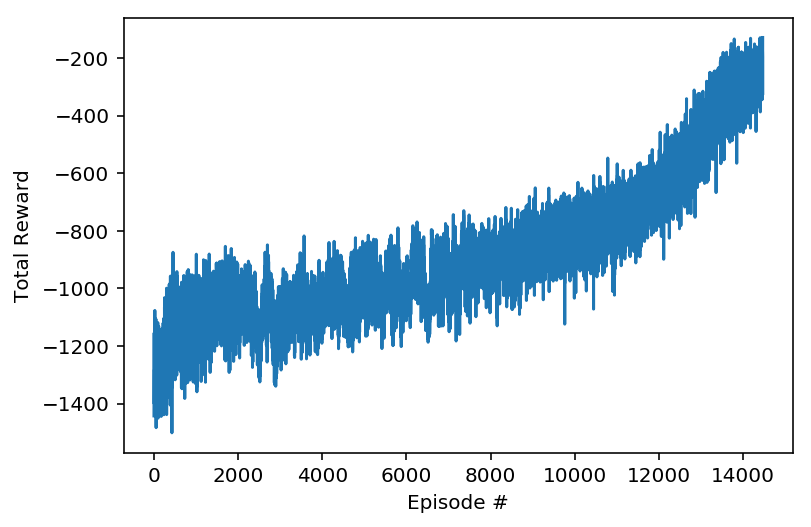

In [11]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

In [51]:
scores = agent.train(max_opt_steps=20000,horizon=200,gamma=0.98,target_score=-200,PRINT_EVERY=100)

Episode: 100	 Avg reward: -251.01	 std: Parameter containing:
tensor([-0.0502], device='cuda:0', requires_grad=True)


/home/g1jaskiratsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Episode: 200	 Avg reward: -230.30	 std: Parameter containing:
tensor([-0.0513], device='cuda:0', requires_grad=True)
Episode: 300	 Avg reward: -230.35	 std: Parameter containing:
tensor([-0.0529], device='cuda:0', requires_grad=True)
Episode: 400	 Avg reward: -243.50	 std: Parameter containing:
tensor([-0.0546], device='cuda:0', requires_grad=True)
Episode: 500	 Avg reward: -233.25	 std: Parameter containing:
tensor([-0.0564], device='cuda:0', requires_grad=True)
Episode: 600	 Avg reward: -235.53	 std: Parameter containing:
tensor([-0.0575], device='cuda:0', requires_grad=True)
Episode: 700	 Avg reward: -229.06	 std: Parameter containing:
tensor([-0.0574], device='cuda:0', requires_grad=True)
Episode: 800	 Avg reward: -222.66	 std: Parameter containing:
tensor([-0.0577], device='cuda:0', requires_grad=True)
Episode: 900	 Avg reward: -221.55	 std: Parameter containing:
tensor([-0.0596], device='cuda:0', requires_grad=True)
Episode: 1000	 Avg reward: -226.72	 std: Parameter containing:
t

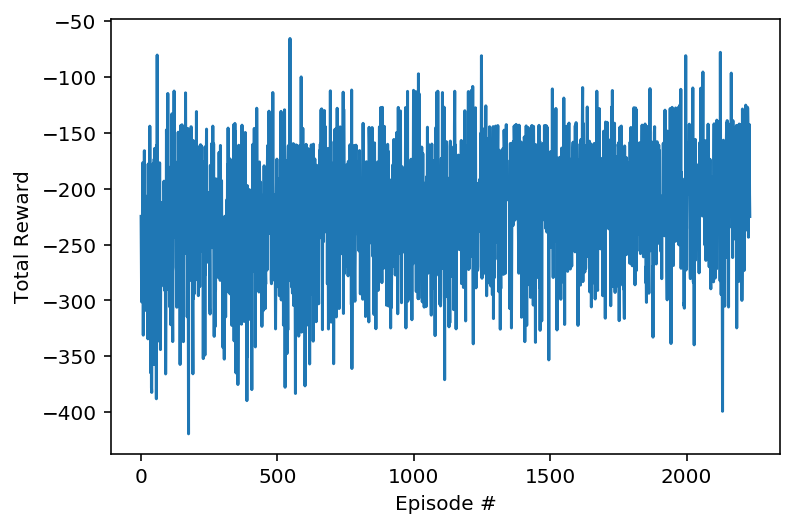

In [91]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

In [93]:
scores = agent.train(max_opt_steps=20000,horizon=200,gamma=0.98,target_score=-180,PRINT_EVERY=100)

Episode: 100	 Avg reward: -204.83	 std: Parameter containing:
tensor([-0.0849], device='cuda:0', requires_grad=True)
Episode: 200	 Avg reward: -212.70	 std: Parameter containing:
tensor([-0.0882], device='cuda:0', requires_grad=True)
Episode: 300	 Avg reward: -204.06	 std: Parameter containing:
tensor([-0.0896], device='cuda:0', requires_grad=True)
Episode: 400	 Avg reward: -198.42	 std: Parameter containing:
tensor([-0.0921], device='cuda:0', requires_grad=True)
Episode: 500	 Avg reward: -193.96	 std: Parameter containing:
tensor([-0.0948], device='cuda:0', requires_grad=True)
Episode: 600	 Avg reward: -191.83	 std: Parameter containing:
tensor([-0.0976], device='cuda:0', requires_grad=True)
Episode: 700	 Avg reward: -188.44	 std: Parameter containing:
tensor([-0.0984], device='cuda:0', requires_grad=True)
Episode: 800	 Avg reward: -193.25	 std: Parameter containing:
tensor([-0.1013], device='cuda:0', requires_grad=True)
Episode: 900	 Avg reward: -188.33	 std: Parameter containing:
te

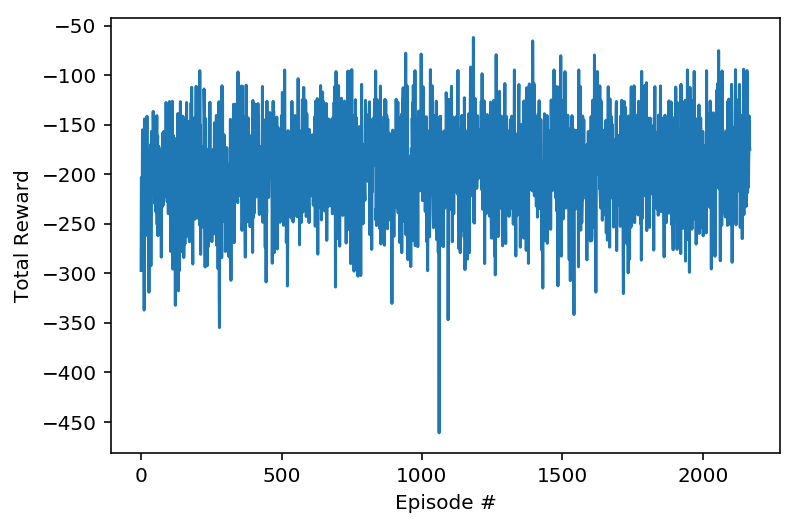

In [117]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

In [118]:
scores = agent.train(max_opt_steps=20000,horizon=200,gamma=0.98,target_score=-150,PRINT_EVERY=100)

Episode: 100	 Avg reward: -189.86	 std: Parameter containing:
tensor([-0.1221], device='cuda:0', requires_grad=True)
Episode: 200	 Avg reward: -185.09	 std: Parameter containing:
tensor([-0.1243], device='cuda:0', requires_grad=True)
Episode: 300	 Avg reward: -196.20	 std: Parameter containing:
tensor([-0.1244], device='cuda:0', requires_grad=True)
Episode: 400	 Avg reward: -190.03	 std: Parameter containing:
tensor([-0.1267], device='cuda:0', requires_grad=True)
Episode: 500	 Avg reward: -185.97	 std: Parameter containing:
tensor([-0.1289], device='cuda:0', requires_grad=True)
Episode: 600	 Avg reward: -183.32	 std: Parameter containing:
tensor([-0.1313], device='cuda:0', requires_grad=True)
Episode: 700	 Avg reward: -193.75	 std: Parameter containing:
tensor([-0.1327], device='cuda:0', requires_grad=True)
Episode: 800	 Avg reward: -185.23	 std: Parameter containing:
tensor([-0.1340], device='cuda:0', requires_grad=True)
Episode: 900	 Avg reward: -180.38	 std: Parameter containing:
te

Episode: 7100	 Avg reward: -177.65	 std: Parameter containing:
tensor([-0.2360], device='cuda:0', requires_grad=True)
Episode: 7200	 Avg reward: -166.10	 std: Parameter containing:
tensor([-0.2361], device='cuda:0', requires_grad=True)
Episode: 7300	 Avg reward: -161.65	 std: Parameter containing:
tensor([-0.2369], device='cuda:0', requires_grad=True)
Episode: 7400	 Avg reward: -172.07	 std: Parameter containing:
tensor([-0.2385], device='cuda:0', requires_grad=True)
Episode: 7500	 Avg reward: -170.58	 std: Parameter containing:
tensor([-0.2404], device='cuda:0', requires_grad=True)
Episode: 7600	 Avg reward: -166.81	 std: Parameter containing:
tensor([-0.2424], device='cuda:0', requires_grad=True)
Episode: 7700	 Avg reward: -170.75	 std: Parameter containing:
tensor([-0.2431], device='cuda:0', requires_grad=True)
Episode: 7800	 Avg reward: -174.26	 std: Parameter containing:
tensor([-0.2447], device='cuda:0', requires_grad=True)
Episode: 7900	 Avg reward: -163.54	 std: Parameter conta

Episode: 14200	 Avg reward: -163.27	 std: Parameter containing:
tensor([-0.3268], device='cuda:0', requires_grad=True)
Episode: 14300	 Avg reward: -158.85	 std: Parameter containing:
tensor([-0.3289], device='cuda:0', requires_grad=True)
Episode: 14400	 Avg reward: -164.00	 std: Parameter containing:
tensor([-0.3299], device='cuda:0', requires_grad=True)
Episode: 14500	 Avg reward: -166.83	 std: Parameter containing:
tensor([-0.3313], device='cuda:0', requires_grad=True)
Episode: 14600	 Avg reward: -173.88	 std: Parameter containing:
tensor([-0.3341], device='cuda:0', requires_grad=True)
Episode: 14700	 Avg reward: -158.93	 std: Parameter containing:
tensor([-0.3349], device='cuda:0', requires_grad=True)
Episode: 14800	 Avg reward: -167.57	 std: Parameter containing:
tensor([-0.3362], device='cuda:0', requires_grad=True)
Episode: 14900	 Avg reward: -161.55	 std: Parameter containing:
tensor([-0.3377], device='cuda:0', requires_grad=True)
Episode: 15000	 Avg reward: -169.32	 std: Parame

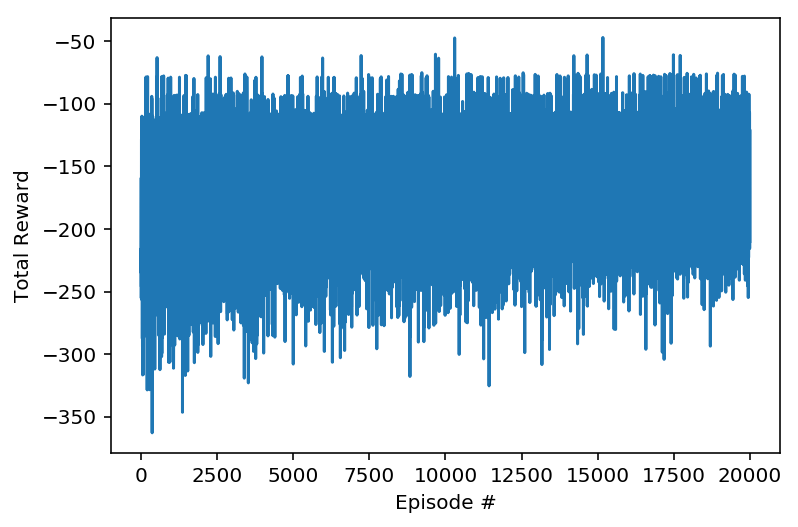

In [169]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

In [ ]:
scores = agent.train(max_opt_steps=20000,horizon=200,gamma=0.98,target_score=-150,PRINT_EVERY=100)

/home/g1jaskiratsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 100	 Avg reward: -163.61	 std: Parameter containing:
tensor([-0.3930], device='cuda:0', requires_grad=True)


/home/g1jaskiratsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Episode: 200	 Avg reward: -169.94	 std: Parameter containing:
tensor([-0.3939], device='cuda:0', requires_grad=True)
Episode: 300	 Avg reward: -161.40	 std: Parameter containing:
tensor([-0.3943], device='cuda:0', requires_grad=True)
Episode: 400	 Avg reward: -166.47	 std: Parameter containing:
tensor([-0.3956], device='cuda:0', requires_grad=True)
Episode: 500	 Avg reward: -167.33	 std: Parameter containing:
tensor([-0.3972], device='cuda:0', requires_grad=True)
Episode: 600	 Avg reward: -163.09	 std: Parameter containing:
tensor([-0.3989], device='cuda:0', requires_grad=True)
Episode: 700	 Avg reward: -159.28	 std: Parameter containing:
tensor([-0.4014], device='cuda:0', requires_grad=True)
Episode: 800	 Avg reward: -167.16	 std: Parameter containing:
tensor([-0.4030], device='cuda:0', requires_grad=True)
Episode: 900	 Avg reward: -160.30	 std: Parameter containing:
tensor([-0.4043], device='cuda:0', requires_grad=True)
Episode: 1000	 Avg reward: -160.91	 std: Parameter containing:
t

Episode: 7600	 Avg reward: -165.59	 std: Parameter containing:
tensor([-0.4850], device='cuda:0', requires_grad=True)
Episode: 7700	 Avg reward: -157.70	 std: Parameter containing:
tensor([-0.4853], device='cuda:0', requires_grad=True)
Episode: 7800	 Avg reward: -163.50	 std: Parameter containing:
tensor([-0.4861], device='cuda:0', requires_grad=True)
Episode: 7900	 Avg reward: -156.10	 std: Parameter containing:
tensor([-0.4862], device='cuda:0', requires_grad=True)
Episode: 8000	 Avg reward: -163.25	 std: Parameter containing:
tensor([-0.4867], device='cuda:0', requires_grad=True)
Episode: 8100	 Avg reward: -164.01	 std: Parameter containing:
tensor([-0.4874], device='cuda:0', requires_grad=True)
Episode: 8200	 Avg reward: -163.49	 std: Parameter containing:
tensor([-0.4894], device='cuda:0', requires_grad=True)
Episode: 8300	 Avg reward: -163.33	 std: Parameter containing:
tensor([-0.4924], device='cuda:0', requires_grad=True)
Episode: 8400	 Avg reward: -158.83	 std: Parameter conta

## 5. Watch the smart agent!

In [ ]:
# uncomment this cell to load the trained policy for Pendulum-v0
# load policy
policy =  torch.load('REINFORCE-Pendulum.policy',map_location='cpu')
agent = Agent(env_name='Pendulum-v0')
agent.policy = policy

In [ ]:
# function to animate a list of frames
def animate_frames(frames):
    plt.figure(dpi = 72)
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
    display(display_animation(fanim, default_mode='once'))

In [177]:
frames = []
total_reward = 0
state = env.reset()
value = []
r = []
for t in range(2000):
    action, _,v = agent.policy.act(state[np.newaxis,:])
    #frames.append(env.render(mode='rgb_array')) 
    next_state, reward, done, _ = env.step(action[0])
    value.append(v.squeeze())
    r.append(reward)
    state=next_state
    total_reward+= reward
    if done:
        break

print ("Total reward:",total_reward)
env.close()
#animate_frames(frames)

Total reward: -117.86849628869433


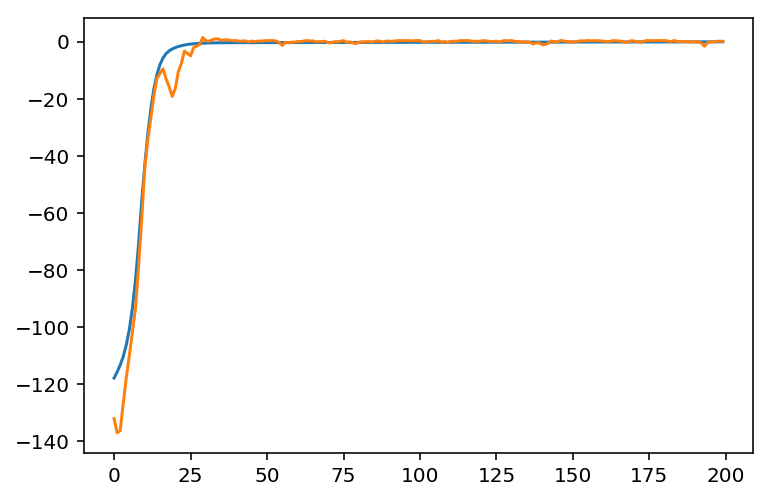

In [178]:
r_ = compute_future_rewards(np.array(r)[np.newaxis,:],gamma=1.0)
plt.plot(r_[0])
plt.plot(value)

In [179]:
agent.policy.std

Parameter containing:
tensor([-0.6119], device='cuda:0', requires_grad=True)